# Importing the Data
Performing attribute reduction by removing empty columns.

In [1]:
DATASET_DIR = './data/' # Datasets to be places here
# pip install pandas
# pip install xlrd

import os
import pandas as pd
import numpy as np

# removing empty columns and finding minimum and maximum scores given to each of the 8 sets

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
# reading from tsv file (tab - separated) with Latin alphabet encoding including special symbols
Y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
Z = pd.read_excel(r'./data/essay_set_descriptions.xlsx')

# minimum and maximum scores for each dataset
minimum_scores = Z['min_domain1_score'].to_list()
minimum_scores.insert(0,-1)
maximum_scores = Z['max_domain1_score'].to_list()
maximum_scores.insert(0,-1)
print('\n----------Essay Set Descriptions----------\n')
print(Z[['essay_set','type_of_essay','training_set_size']])

print('\nMinimum scores for each essay set:')
print(minimum_scores[1:9])
print('\nMaximum scores for each essay set:')
print(maximum_scores[1:9])


----------Essay Set Descriptions----------

   essay_set                         type_of_essay  training_set_size
0          1  persuasive / narrative  / expository               1783
1          2  persuasive / narrative  / expository               1800
2          3            source dependent responses               1726
3          4            source dependent responses               1772
4          5            source dependent responses               1805
5          6            source dependent responses               1800
6          7  persuasive / narrative  / expository               1569
7          8  persuasive / narrative  / expository                723

Minimum scores for each essay set:
[2, 1, 0, 0, 0, 0, 0, 0]

Maximum scores for each essay set:
[12, 6, 3, 3, 4, 4, 30, 60]


## Main Dataframe
Our main dataframe consists of 12975 sample essays which goes upto essay_id 21633 and are divided into 8 sets.

In [2]:
X

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


## Pre-processing of the Data

These are all helper functions used to clean and tokenize the essays into sentences and wordlists.

In [3]:
# !pip install gensim for Word2vec and Fasttext Model
# !pip install nltk for natural Language Processing 

import nltk
# first time run download these packages
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('popular')

import re # for regular expressions operations 
from nltk.corpus import stopwords

def essay_to_wordlist(essay_v, remove_stopwords):
    # remove the tagged labels and word tokenize the sentence
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v) # removing anything that is not alphabetic
    words = essay_v.lower().split() # turn sentence into lowercase and split it into words 
    if remove_stopwords:
        stops = set(stopwords.words("english")) # english stopwords library 
        words = [w for w in words if not w in stops] 
        # words present in the sentence and not present in stopwords
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    # sentence tokenize the essay and call essay_to_wordlist() for word tokenization
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # nltk library
    raw_sentences = tokenizer.tokenize(essay_v.strip()) # call tokenizer on essay striped of spaces 
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
            # remove_stopwords carried forward to essay_to_wordlist it is a bool variable
    return sentences # will be returning list of tokenized sentences without stopwords

def makeFeatureVec(words, model, num_features):
    # make Feature Vector from the words list of an Essay
    featureVec = np.zeros((num_features,),dtype="float32")
    #  make null vectors of length = num_features for every word index
    num_words = 0.
    index2word_set = set(model.wv.index2word) # vocabulary set of model
    for word in words:
        if word in index2word_set: # for word in a sentence being in index2word_set
            num_words += 1
            featureVec = np.add(featureVec,model.wv[word])
    if num_words:
        featureVec = np.divide(featureVec,num_words) 
        # divides every element of featureVec by num_words (to compute average) 
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    # main function to generate the word vectors for word2vec model
    # it then calls makeFeatureVec and for every essay sentance
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    # make null vectors of length = length of essay having null vector of num_features at every index
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs
    # then returns the trained model feature vectors

## Word embeddings
We will preprocess all essays and convert them to feature vectors using Word2vec and Fasttext model. We would also perform transfer learning by using pre-trained Word2vec, GloVe and Fasttext models.

All the word embeddings used are 300 dimentional vectors.

In [4]:
# initializing variables for word2vec and fasttext model.
num_features = 300 # vector length
min_word_count = 40 # to be considered for vectorisation
num_workers = 8 # working cores
context = 10
downsampling = 1e-3 # compressing

## Word2Vec Model
Using word2vec model to make embeddings for visualization.

In [5]:
from gensim.models import Word2Vec # for word2vec
from gensim.test.utils import get_tmpfile # for saving model

allsentences = [] # list of all sentences

for essay in X['essay']:
# obtaining all sentences from the essays.
    allsentences += essay_to_sentences(essay, remove_stopwords=True)

# for visualization of vectors
visualmodel = Word2Vec(
    allsentences, 
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context, 
    sample=downsampling
)

path = get_tmpfile("./word2vecvis/word2vecvisual.model") # path for the model 

visualmodel.init_sims(replace=True) # normalized model
# different ways to save model
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.txt', binary=False)
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.bin', binary=True)
visualmodel.save("./word2vecvis/word2vecvisual.model")

# embedding dataframe
M=visualmodel.wv[visualmodel.wv.vocab]
df=pd.DataFrame(M)
pd.options.display.max_columns=10
df

,0,1,2,3,4,...,295,296,297,298,299
0,0.021425,-0.053463,-0.052423,0.064400,0.115584,...,0.018841,-0.148235,0.063995,0.031970,0.087408
1,-0.004673,-0.088627,-0.054765,0.005076,0.071242,...,0.041199,-0.114119,0.096822,0.071800,0.046511
2,-0.007502,-0.055352,-0.022126,0.070755,0.072975,...,0.022588,-0.104080,0.111521,0.053943,0.068887
3,-0.175582,-0.028774,0.121223,0.044549,0.062101,...,-0.004725,-0.120057,0.056831,-0.019165,0.039742
4,-0.050460,-0.038637,0.086461,0.047639,0.098701,...,-0.008766,-0.068949,0.071667,-0.003863,0.117454
...,...,...,...,...,...,...,...,...,...,...,...
2897,0.100395,-0.047956,-0.092907,-0.012097,-0.019249,...,-0.041499,0.108295,-0.015704,-0.017556,-0.059858
2898,0.007653,-0.043560,-0.018565,-0.001236,-0.046051,...,0.107480,0.116371,0.014855,0.040547,-0.010059
2899,-0.030321,-0.054307,-0.071106,0.011284,-0.040522,...,0.108078,0.031446,-0.024112,0.007441,0.011072
2900,0.006728,-0.041975,-0.016309,0.016274,-0.011536,...,0.092325,0.074321,0.014019,0.046401,-0.037158


## Pre-Trained Word2Vec Model
It is trained on the Google News dataset (about 100 billion words).

In [6]:
from gensim.models import KeyedVectors

modelbasic = Word2Vec.load('./word2vecvis/word2vecvisual.model')
# getting embeddings from pretrained word2vec model 
modelbasic.intersect_word2vec_format('./word2vec/word2vec.bin', binary=True, lockf=1.0)

# will be using on training data
# modelbasic.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.iter)
# modelbasic.init_sims(replace=True) # for normalizing
# modelbasic.save("./word2vec/word2vecPre.model")

## Pre-Trained Glove Model
It is trained on Wikipedia data and contains about 6 billion words in its vocabulary. 

In [7]:
from gensim.scripts.glove2word2vec import glove2word2vec

modelglove = Word2Vec.load('./word2vecvis/word2vecvisual.model')
# Converting Glove to Word2Vec
_ = glove2word2vec('./glove/glove.6B.300d.txt', "./glove/gloveW2V.txt")
# Getting embeddings from pretrained Glove model
modelglove.intersect_word2vec_format('./glove/gloveW2V.txt', binary=False, lockf=1.0)

# will be using on training data
# modelglove.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.iter)
# modelglove.init_sims(replace=True) for normalizing
# modelglove.save("./glove/gloveW2V.model")

## Fasttext
It is similar to word2vec model but also contains embeddings for n-grams which hep in data sets with out of vocabulary words.

In [8]:
from gensim.models.fasttext import FastText

ftmodel = FastText(
    allsentences, 
    workers=num_workers, 
    size=num_features, 
    min_count = min_word_count, 
    window = context, 
    sample = downsampling
)
# ftmodel.save("./fasttext/fasttext.model") for saving with ngrams

# embedding dataframe
F=ftmodel.wv[ftmodel.wv.vocab]
ft=pd.DataFrame(F)
pd.options.display.max_columns=10
ft

,0,1,2,3,4,...,295,296,297,298,299
0,0.613249,-0.864311,-0.103734,-0.025468,0.514903,...,0.047517,2.842318,-0.362014,-0.592446,-0.613923
1,0.108938,-0.255891,-0.050898,-0.066125,0.918657,...,0.065667,0.519624,-0.389563,0.052835,0.089516
2,-0.118172,-0.145609,-0.142844,-0.237425,0.797495,...,-0.112584,0.999265,-0.464127,0.356061,-1.131099
3,-0.852168,0.160208,0.463684,0.612816,-0.213453,...,-0.418813,0.635375,-0.362428,0.085810,-0.990671
4,0.417107,0.372219,-0.019516,-0.148007,0.367151,...,0.139195,0.685474,-0.041437,-0.257969,-0.949122
...,...,...,...,...,...,...,...,...,...,...,...
2897,1.223074,1.005983,-0.911485,-1.261347,-0.914959,...,0.132237,0.311351,0.389749,0.087270,0.340563
2898,0.011850,-0.199783,-0.100318,0.102046,0.038606,...,-0.368845,0.174177,-0.148070,0.166914,0.228041
2899,0.139838,-0.367371,-0.240118,-0.004498,-0.169250,...,0.665431,0.141019,0.044590,-0.658601,0.604211
2900,0.319987,0.277432,-0.209039,-0.367988,0.612152,...,-0.040918,-0.129401,0.275608,0.119335,-0.040279


## Pre-Trained Fasttext Model
It is the fasttext model pre-trained on Wiki-news also containing sub-words data.

In [9]:
ftmodelPre = Word2Vec.load('./word2vecvis/word2vecvisual.model')
total_examples = ftmodelPre.corpus_count
# Getting embeddings from pretrained Fasttext model 
ftmodelPre.intersect_word2vec_format('./fasttext/wiki-news-300d-1M-subword.vec')

# will be using on training data
# ftmodelPre.train(allsentences,total_examples=len(allsentences), epochs=ftmodel.iter)
# ftmodelPre.save("./fasttext/fasttextPre.model") for saving with ngrams

## Visualization
Files needed for visualization on Embedding Projector, Tensorflow.

In [10]:
# Storing Visual model tsv files
import io # for input output

# files needed for tensorboard
out_v = io.open('./word2vecvis/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./word2vecvis/meta.tsv', 'w', encoding='utf-8')

# write meta file and vector file
for index in range(len(visualmodel.wv.index2word)): # for every word in vocab
    word = visualmodel.wv.index2word[index]
    vec = visualmodel.wv.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Open http://projector.tensorflow.org/
# Click “Load Data” button from the left menu.
# Select “Choose file” in “Load a TSV file of vectors.” and choose “vecs.tsv” file.
# Select “Choose file” in “Load a TSV file of metadata.” and choose “meta.tsv” file.
# The model has been visualized in 3D/2D.
# It is done on choosing variable with higher variance as a dimension from the vector

## Exploratory Analysis
It is performed using Principal Component Analysis(PCA)


 300.0000000000012

1. Variance Explained
 [14.017821096595132, 10.882704068550135, 7.820623617436083, 6.861932738318846, 5.669153329032148]

2. Cumulative Variance Explained
 [14.0178211  24.90052517 32.72114878 39.58308152 45.25223485]

 [[ 0.17025616 -0.01063641]
 [ 0.04060755 -0.28744997]
 [ 0.25706912 -0.21560269]
 ...
 [-0.57141518 -0.19124723]
 [-0.37174742 -0.22539283]
 [-0.04367813 -0.19105536]]


<BarContainer object of 5 artists>

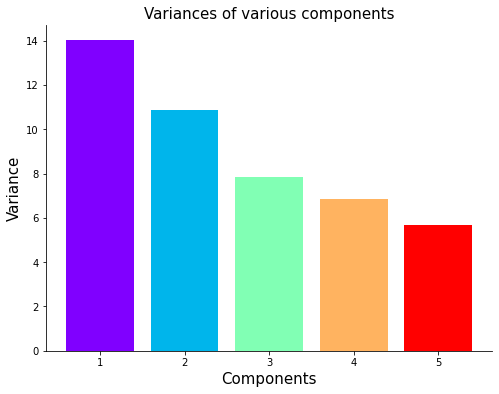

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Computing the correlation matrix
M_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(M_corr)


# Sorting the eigen vectors coresponding to eigen values in descending order is done like 
# this to have us choosing best eigenvector for infogain. But in our model its already 
# sorted the way it should be. Eigenvector with highest eigenvalue in the first column.
# args = (-values).argsort()
# values = vectors[args]
# vectors = vectors[:, args]

# our aim is to cover maximum variance possible 
# no. of components selected = no. of plotting dimensions
tot = sum(values) # summation of eigenvalues
print("\n",tot) 
var_exp = [(i / tot)*100 for i in values[:5]] # first 5 variance in desc order
print("\n1. Variance Explained\n",var_exp) 
cum_var_exp = np.cumsum(var_exp) # first 5 cumulative variance
print("\n2. Cumulative Variance Explained\n",cum_var_exp) 

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

new_M=np.dot(M,new_vectors)
print("\n",new_M) # coordinates for 2D plot

plt.figure(figsize=(8,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Variances of various components',size=15)
plt.xlabel("Components",size=15)
plt.ylabel('Variance',size=15)
plt.bar(range(1,6),
        var_exp,
        width=0.8,
        color = cm.rainbow(np.linspace(0, 1, len(var_exp))))

## Word Embedding Plot
Using PCA we have done plotting of the vectors in a 2-dimentional space 

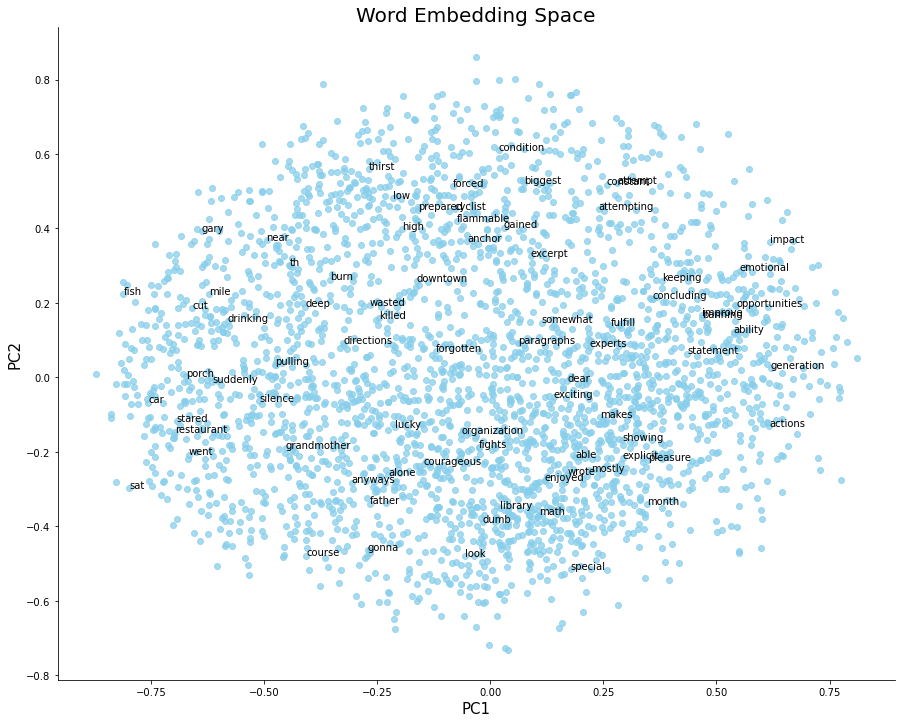

In [12]:
#Plotting
plt.figure(figsize=(15,12))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(new_M[:,0],new_M[:,1],linewidths=1,color='skyblue',alpha=0.75)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(visualmodel.wv.vocab)
for i, word in enumerate(vocab):
  if i%37==0:
      plt.annotate(word,xy=(new_M[i,0],new_M[i,1])) # selective annotations
  

## Defining the model 
We have used three types of models namely:
Dual layer LSTM, Bi-directional LSTM, Convolutional neural network LSTM

In [13]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from keras.models import Sequential
import keras.backend as K

# bidirectional is for evaluating input in both sequential order
# conv1D is for adding a Cnn layer instead of a LSTM layer
# return sequences return sequences in shape for next Lstm layer
# dropout layers are for regularization
# dropout is for inputs and recurrent dropout is for recurrent inputs
# instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.
# x is 0-> Dual layer LSTM, 1-> Bidirectional LSTM, 2-> CNN LSTM 

def get_model(x):
    model = Sequential()
    if x == 0:
        model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    if x == 1:
        model.add(Bidirectional(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True)))
    if x == 2:
        model.add(Conv1D(64, 3, activation='relu',input_shape=(1,300),padding='same'))
        model.add(Dropout(0.4))
    model.add(LSTM(128, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    if x == 1:
        model.build((None,1,300))
    model.summary()
    return model

## Training Phase
Here we will train our data for 5 types of word embeddings and 3 types of LSTM Networks. And store the respective Kappa Scores in the dataframe and them will do comparative analysis.


Shape of X_train and y_train respectively.

(9083, 4) (9083,)
(3893, 4) (3893,)

------------------- Dual-LSTM Model with W2V Embeddings -------------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 6s 21ms/step - loss: 49.2815 - mae

284/284 [==============================] - 4s 13ms/step - loss: 5.4637 - mae: 1.3238 - val_loss: 5.3950 - val_mae: 1.2639
Epoch 54/100
284/284 [==============================] - 4s 13ms/step - loss: 5.7192 - mae: 1.3435 - val_loss: 5.3252 - val_mae: 1.2598
Epoch 55/100
284/284 [==============================] - 4s 13ms/step - loss: 5.7766 - mae: 1.3311 - val_loss: 5.3818 - val_mae: 1.2608
Epoch 56/100
284/284 [==============================] - 4s 13ms/step - loss: 5.4158 - mae: 1.3201 - val_loss: 5.2953 - val_mae: 1.2559
Epoch 57/100
284/284 [==============================] - 3s 11ms/step - loss: 5.5181 - mae: 1.3285 - val_loss: 5.2844 - val_mae: 1.2548
Epoch 58/100
284/284 [==============================] - 3s 11ms/step - loss: 5.7337 - mae: 1.3333 - val_loss: 5.3015 - val_mae: 1.2506
Epoch 59/100
284/284 [==============================] - 3s 12ms/step - loss: 5.6510 - mae: 1.3338 - val_loss: 5.2075 - val_mae: 1.2402
Epoch 60/100
284/284 [==============================] - 3s 11ms/step

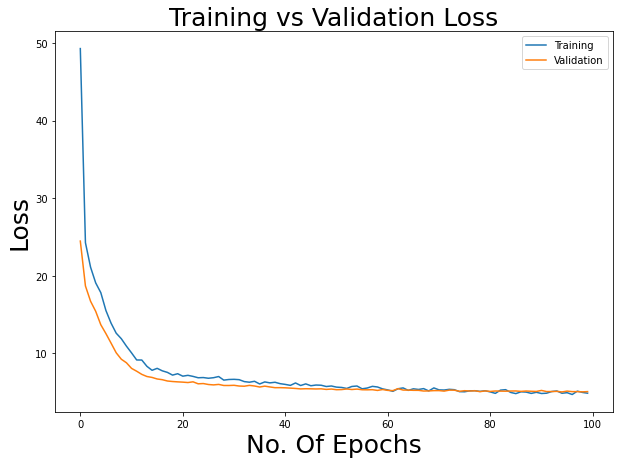


Kappa Score: 0.9661113282327244

------------------- Dual-LSTM Model with W2V Embeddings -------------------


------------------- Bi-LSTM Model with W2V Embeddings -------------------

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 600)            1442400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               373248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 

284/284 [==============================] - 6s 20ms/step - loss: 5.2843 - mae: 1.2990 - val_loss: 5.1017 - val_mae: 1.2131
Epoch 54/100
284/284 [==============================] - 6s 20ms/step - loss: 5.2565 - mae: 1.2871 - val_loss: 5.1238 - val_mae: 1.2154
Epoch 55/100
284/284 [==============================] - 6s 20ms/step - loss: 5.2464 - mae: 1.2955 - val_loss: 5.1143 - val_mae: 1.2181
Epoch 56/100
284/284 [==============================] - 6s 20ms/step - loss: 5.1464 - mae: 1.2826 - val_loss: 5.0863 - val_mae: 1.2098
Epoch 57/100
284/284 [==============================] - 8s 27ms/step - loss: 5.1274 - mae: 1.2882 - val_loss: 5.0177 - val_mae: 1.2034
Epoch 58/100
284/284 [==============================] - 10s 34ms/step - loss: 5.0639 - mae: 1.2903 - val_loss: 5.0819 - val_mae: 1.2028
Epoch 59/100
284/284 [==============================] - 8s 29ms/step - loss: 4.8766 - mae: 1.2623 - val_loss: 4.9525 - val_mae: 1.2013
Epoch 60/100
284/284 [==============================] - 8s 28ms/ste

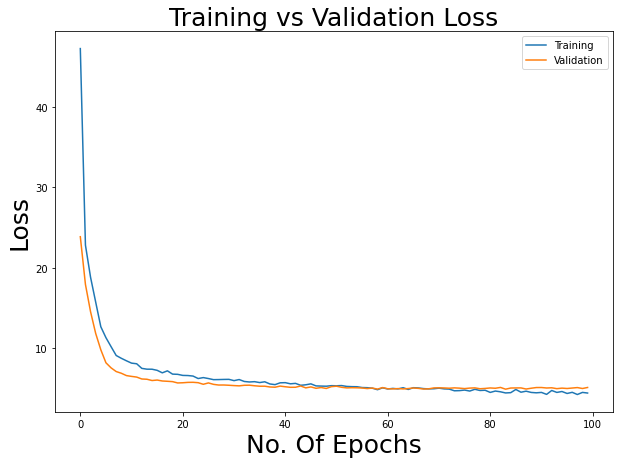


Kappa Score: 0.9656699339208563

------------------- Bi-LSTM Model with W2V Embeddings -------------------


------------------- Cnn-LSTM Model with W2V Embeddings -------------------

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             57664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable para

284/284 [==============================] - 1s 4ms/step - loss: 6.6874 - mae: 1.4479 - val_loss: 6.6457 - val_mae: 1.3305
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 6.7686 - mae: 1.4466 - val_loss: 6.6782 - val_mae: 1.3426
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 6.6405 - mae: 1.4353 - val_loss: 6.6557 - val_mae: 1.3306
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 6.5670 - mae: 1.4369 - val_loss: 6.4618 - val_mae: 1.3236
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 6.3281 - mae: 1.4244 - val_loss: 6.5279 - val_mae: 1.3285
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 6.6288 - mae: 1.4382 - val_loss: 6.4912 - val_mae: 1.3192
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 6.4635 - mae: 1.4190 - val_loss: 6.4541 - val_mae: 1.3180
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

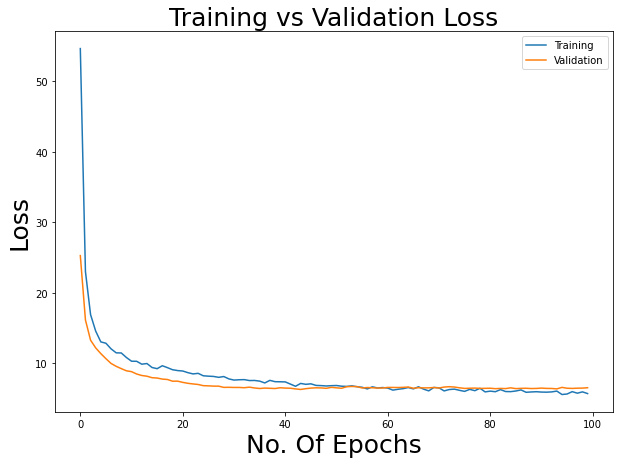


Kappa Score: 0.9558751821347782

------------------- Cnn-LSTM Model with W2V Embeddings -------------------


------------------- Dual-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 6s

284/284 [==============================] - 4s 15ms/step - loss: 5.6544 - mae: 1.3656 - val_loss: 4.9531 - val_mae: 1.2680
Epoch 54/100
284/284 [==============================] - 4s 15ms/step - loss: 5.3356 - mae: 1.3571 - val_loss: 5.0072 - val_mae: 1.2665
Epoch 55/100
284/284 [==============================] - 4s 15ms/step - loss: 5.4649 - mae: 1.3560 - val_loss: 4.9386 - val_mae: 1.2610
Epoch 56/100
284/284 [==============================] - 4s 16ms/step - loss: 5.4874 - mae: 1.3575 - val_loss: 4.8855 - val_mae: 1.2579
Epoch 57/100
284/284 [==============================] - 4s 15ms/step - loss: 5.1922 - mae: 1.3281 - val_loss: 4.8915 - val_mae: 1.2529
Epoch 58/100
284/284 [==============================] - 4s 15ms/step - loss: 5.0733 - mae: 1.3272 - val_loss: 4.9018 - val_mae: 1.2516
Epoch 59/100
284/284 [==============================] - 6s 21ms/step - loss: 5.1321 - mae: 1.3238 - val_loss: 4.8766 - val_mae: 1.2462
Epoch 60/100
284/284 [==============================] - 5s 17ms/step

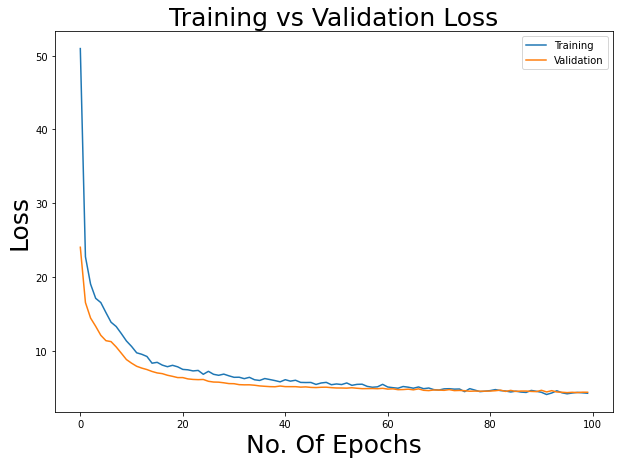


Kappa Score: 0.970292833067501

------------------- Dual-LSTM Model with W2VP Embeddings -------------------


------------------- Bi-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               373248    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] -

Epoch 53/100
284/284 [==============================] - 8s 28ms/step - loss: 4.5655 - mae: 1.2379 - val_loss: 4.1640 - val_mae: 1.1498
Epoch 54/100
284/284 [==============================] - 8s 28ms/step - loss: 4.6402 - mae: 1.2499 - val_loss: 4.4209 - val_mae: 1.1655
Epoch 55/100
284/284 [==============================] - 10s 34ms/step - loss: 4.3472 - mae: 1.2307 - val_loss: 4.1538 - val_mae: 1.1481
Epoch 56/100
284/284 [==============================] - 8s 28ms/step - loss: 4.6006 - mae: 1.2377 - val_loss: 4.1589 - val_mae: 1.1499
Epoch 57/100
284/284 [==============================] - 8s 28ms/step - loss: 4.5126 - mae: 1.2363 - val_loss: 4.1802 - val_mae: 1.1466
Epoch 58/100
284/284 [==============================] - 8s 27ms/step - loss: 4.4322 - mae: 1.2301 - val_loss: 4.4981 - val_mae: 1.1640
Epoch 59/100
284/284 [==============================] - 10s 34ms/step - loss: 4.3113 - mae: 1.2184 - val_loss: 4.3058 - val_mae: 1.1609
Epoch 60/100
284/284 [==============================]

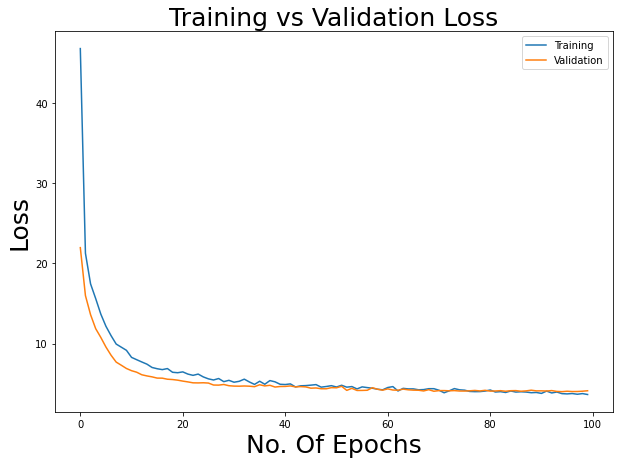


Kappa Score: 0.9720725941748533

------------------- Bi-LSTM Model with W2VP Embeddings -------------------


------------------- Cnn-LSTM Model with W2VP Embeddings -------------------

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable pa

284/284 [==============================] - 1s 3ms/step - loss: 5.1865 - mae: 1.3196 - val_loss: 5.7517 - val_mae: 1.2750
Epoch 52/100
284/284 [==============================] - 1s 3ms/step - loss: 5.3041 - mae: 1.3261 - val_loss: 5.7645 - val_mae: 1.2748
Epoch 53/100
284/284 [==============================] - 1s 3ms/step - loss: 5.1255 - mae: 1.3167 - val_loss: 5.8059 - val_mae: 1.2724
Epoch 54/100
284/284 [==============================] - 1s 3ms/step - loss: 4.9985 - mae: 1.3028 - val_loss: 5.7609 - val_mae: 1.2669
Epoch 55/100
284/284 [==============================] - 1s 3ms/step - loss: 5.0691 - mae: 1.3040 - val_loss: 5.9428 - val_mae: 1.2835
Epoch 56/100
284/284 [==============================] - 1s 3ms/step - loss: 5.1491 - mae: 1.3180 - val_loss: 5.8704 - val_mae: 1.2702
Epoch 57/100
284/284 [==============================] - 1s 3ms/step - loss: 4.8274 - mae: 1.2909 - val_loss: 5.8541 - val_mae: 1.2694
Epoch 58/100
284/284 [==============================] - 1s 3ms/step - loss:

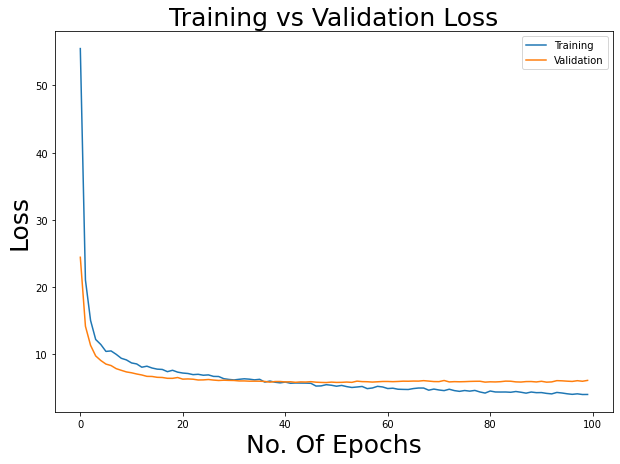


Kappa Score: 0.9593899810306594

------------------- Cnn-LSTM Model with W2VP Embeddings -------------------


------------------- Dual-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 

284/284 [==============================] - 4s 12ms/step - loss: 5.1316 - mae: 1.3034 - val_loss: 4.9916 - val_mae: 1.2265
Epoch 54/100
284/284 [==============================] - 4s 12ms/step - loss: 5.2787 - mae: 1.3006 - val_loss: 4.7827 - val_mae: 1.2213
Epoch 55/100
284/284 [==============================] - 4s 13ms/step - loss: 5.2113 - mae: 1.3098 - val_loss: 4.8718 - val_mae: 1.2172
Epoch 56/100
284/284 [==============================] - 4s 12ms/step - loss: 5.1450 - mae: 1.2858 - val_loss: 4.7787 - val_mae: 1.2048
Epoch 57/100
284/284 [==============================] - 4s 12ms/step - loss: 5.0313 - mae: 1.2943 - val_loss: 4.8036 - val_mae: 1.2092
Epoch 58/100
284/284 [==============================] - 4s 13ms/step - loss: 4.9575 - mae: 1.2843 - val_loss: 4.8294 - val_mae: 1.2125
Epoch 59/100
284/284 [==============================] - 4s 13ms/step - loss: 4.9938 - mae: 1.2902 - val_loss: 4.7573 - val_mae: 1.2116
Epoch 60/100
284/284 [==============================] - 4s 12ms/step

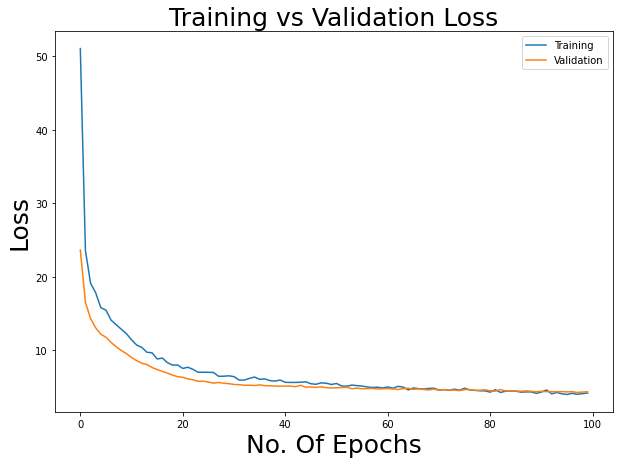


Kappa Score: 0.970284326286603

------------------- Dual-LSTM Model with GloVe Embeddings -------------------


------------------- Bi-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================]

284/284 [==============================] - 8s 29ms/step - loss: 4.7219 - mae: 1.2576 - val_loss: 4.6507 - val_mae: 1.1742
Epoch 54/100
284/284 [==============================] - 8s 28ms/step - loss: 4.4714 - mae: 1.2432 - val_loss: 4.5477 - val_mae: 1.1660
Epoch 55/100
284/284 [==============================] - 8s 29ms/step - loss: 4.4662 - mae: 1.2304 - val_loss: 4.6869 - val_mae: 1.1782
Epoch 56/100
284/284 [==============================] - 8s 29ms/step - loss: 4.4569 - mae: 1.2328 - val_loss: 4.4040 - val_mae: 1.1545
Epoch 57/100
284/284 [==============================] - 8s 29ms/step - loss: 4.6073 - mae: 1.2441 - val_loss: 4.4154 - val_mae: 1.1597
Epoch 58/100
284/284 [==============================] - 8s 29ms/step - loss: 4.4107 - mae: 1.2243 - val_loss: 4.3995 - val_mae: 1.1523
Epoch 59/100
284/284 [==============================] - 8s 28ms/step - loss: 4.4783 - mae: 1.2430 - val_loss: 4.4625 - val_mae: 1.1551
Epoch 60/100
284/284 [==============================] - 7s 25ms/step

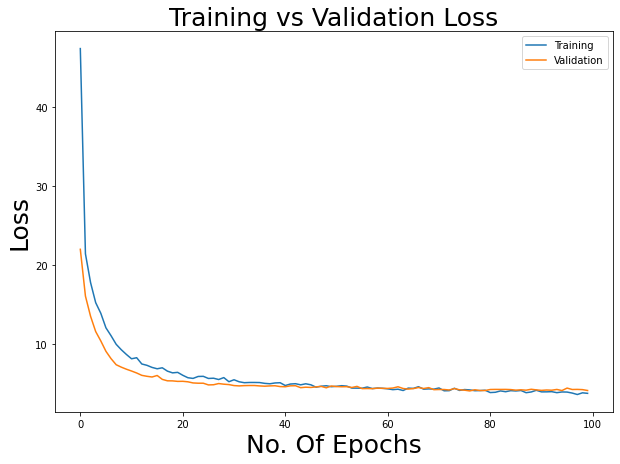


Kappa Score: 0.9715342606273737

------------------- Bi-LSTM Model with GloVe Embeddings -------------------


------------------- Cnn-LSTM Model with GloVe Embeddings -------------------

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable 

284/284 [==============================] - 1s 4ms/step - loss: 5.1578 - mae: 1.3130 - val_loss: 5.7511 - val_mae: 1.2712
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 5.2041 - mae: 1.3256 - val_loss: 5.7158 - val_mae: 1.2713
Epoch 55/100
284/284 [==============================] - 1s 5ms/step - loss: 5.2720 - mae: 1.3405 - val_loss: 5.7254 - val_mae: 1.2695
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 5.2216 - mae: 1.3282 - val_loss: 5.7955 - val_mae: 1.2750
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 5.0201 - mae: 1.3133 - val_loss: 5.7667 - val_mae: 1.2714
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 4.9693 - mae: 1.3022 - val_loss: 5.7071 - val_mae: 1.2660
Epoch 59/100
284/284 [==============================] - 1s 5ms/step - loss: 4.9760 - mae: 1.2989 - val_loss: 5.7563 - val_mae: 1.2729
Epoch 60/100
284/284 [==============================] - 1s 5ms/step - loss:

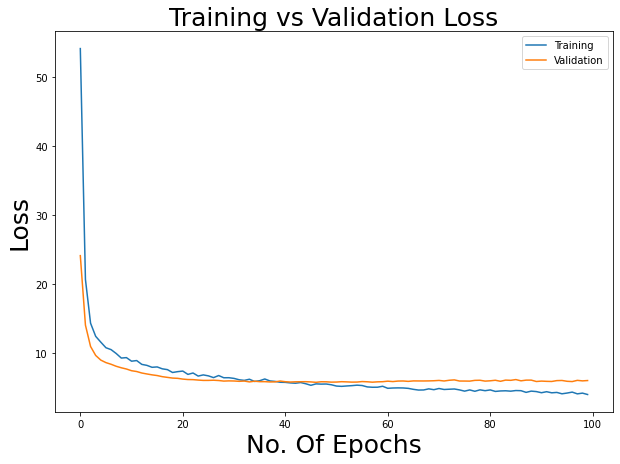


Kappa Score: 0.9602048532182776

------------------- Cnn-LSTM Model with GloVe Embeddings -------------------


------------------- Dual-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] -

284/284 [==============================] - 4s 15ms/step - loss: 5.5781 - mae: 1.3593 - val_loss: 5.5060 - val_mae: 1.2856
Epoch 54/100
284/284 [==============================] - 4s 14ms/step - loss: 6.0568 - mae: 1.3887 - val_loss: 5.4620 - val_mae: 1.2873
Epoch 55/100
284/284 [==============================] - 5s 16ms/step - loss: 5.7054 - mae: 1.3694 - val_loss: 5.3495 - val_mae: 1.2741
Epoch 56/100
284/284 [==============================] - 4s 14ms/step - loss: 5.9383 - mae: 1.3775 - val_loss: 5.4732 - val_mae: 1.2804
Epoch 57/100
284/284 [==============================] - 4s 14ms/step - loss: 5.4142 - mae: 1.3443 - val_loss: 5.4767 - val_mae: 1.2781
Epoch 58/100
284/284 [==============================] - 5s 16ms/step - loss: 5.4113 - mae: 1.3384 - val_loss: 5.3768 - val_mae: 1.2688
Epoch 59/100
284/284 [==============================] - 4s 15ms/step - loss: 5.5833 - mae: 1.3512 - val_loss: 5.3093 - val_mae: 1.2647
Epoch 60/100
284/284 [==============================] - 5s 16ms/step

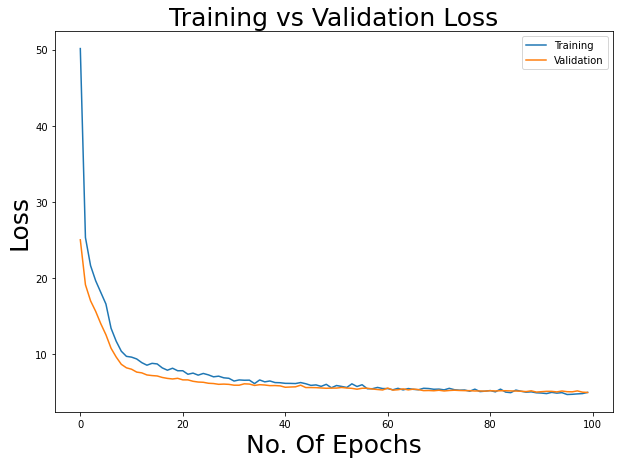


Kappa Score: 0.9665399971252038

------------------- Dual-LSTM Model with FsTxT Embeddings -------------------


------------------- Bi-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [=============================

284/284 [==============================] - 8s 27ms/step - loss: 5.2104 - mae: 1.2881 - val_loss: 5.2927 - val_mae: 1.2298
Epoch 54/100
284/284 [==============================] - 10s 34ms/step - loss: 4.9592 - mae: 1.2856 - val_loss: 5.3412 - val_mae: 1.2368
Epoch 55/100
284/284 [==============================] - 8s 29ms/step - loss: 5.2672 - mae: 1.3045 - val_loss: 5.3426 - val_mae: 1.2291
Epoch 56/100
284/284 [==============================] - 7s 26ms/step - loss: 5.2174 - mae: 1.2968 - val_loss: 5.2634 - val_mae: 1.2230
Epoch 57/100
284/284 [==============================] - 7s 25ms/step - loss: 5.1977 - mae: 1.2999 - val_loss: 5.2691 - val_mae: 1.2311
Epoch 58/100
284/284 [==============================] - 7s 26ms/step - loss: 5.2702 - mae: 1.2996 - val_loss: 5.2088 - val_mae: 1.2196
Epoch 59/100
284/284 [==============================] - 8s 27ms/step - loss: 5.2506 - mae: 1.2958 - val_loss: 5.4781 - val_mae: 1.2459
Epoch 60/100
284/284 [==============================] - 8s 28ms/ste

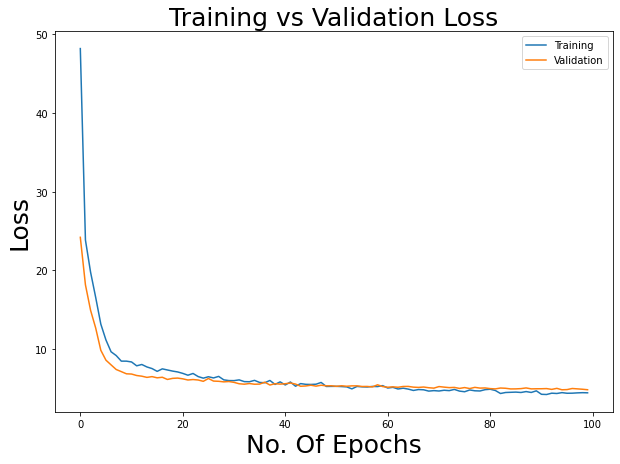


Kappa Score: 0.9671028085002404

------------------- Bi-LSTM Model with FsTxT Embeddings -------------------


------------------- Cnn-LSTM Model with FsTxT Embeddings -------------------

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainable

284/284 [==============================] - 1s 4ms/step - loss: 6.4951 - mae: 1.4529 - val_loss: 6.5763 - val_mae: 1.3398
Epoch 54/100
284/284 [==============================] - 1s 3ms/step - loss: 6.3425 - mae: 1.4263 - val_loss: 6.7140 - val_mae: 1.3435
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 6.5778 - mae: 1.4470 - val_loss: 6.5781 - val_mae: 1.3463
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 6.3997 - mae: 1.4334 - val_loss: 6.5910 - val_mae: 1.3436
Epoch 57/100
284/284 [==============================] - 1s 5ms/step - loss: 6.6172 - mae: 1.4480 - val_loss: 6.6219 - val_mae: 1.3425
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 6.5917 - mae: 1.4472 - val_loss: 6.5630 - val_mae: 1.3429
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 6.4544 - mae: 1.4218 - val_loss: 6.4960 - val_mae: 1.3319
Epoch 60/100
284/284 [==============================] - 1s 4ms/step - loss:

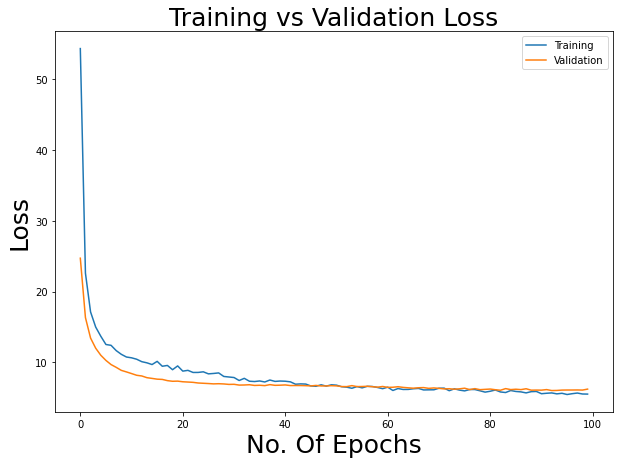


Kappa Score: 0.9576898920531834

------------------- Cnn-LSTM Model with FsTxT Embeddings -------------------


------------------- Dual-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================]

284/284 [==============================] - 4s 13ms/step - loss: 8.9822 - mae: 1.6793 - val_loss: 6.9494 - val_mae: 1.4412
Epoch 54/100
284/284 [==============================] - 4s 13ms/step - loss: 9.3797 - mae: 1.6954 - val_loss: 6.8705 - val_mae: 1.4390
Epoch 55/100
284/284 [==============================] - 4s 13ms/step - loss: 8.7157 - mae: 1.6725 - val_loss: 6.9626 - val_mae: 1.4629
Epoch 56/100
284/284 [==============================] - 4s 13ms/step - loss: 9.2555 - mae: 1.6882 - val_loss: 7.1479 - val_mae: 1.4519
Epoch 57/100
284/284 [==============================] - 4s 13ms/step - loss: 8.6062 - mae: 1.6497 - val_loss: 6.7779 - val_mae: 1.4360
Epoch 58/100
284/284 [==============================] - 4s 13ms/step - loss: 8.7873 - mae: 1.6522 - val_loss: 7.0902 - val_mae: 1.4573
Epoch 59/100
284/284 [==============================] - 4s 13ms/step - loss: 8.9790 - mae: 1.6639 - val_loss: 6.9747 - val_mae: 1.4774
Epoch 60/100
284/284 [==============================] - 4s 13ms/step

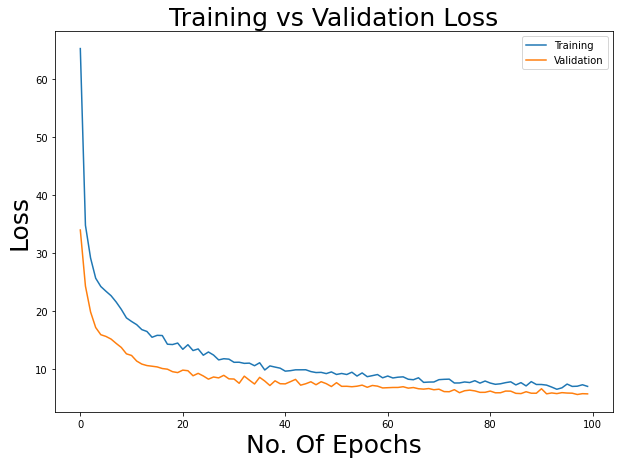


Kappa Score: 0.9625261849337481

------------------- Dual-LSTM Model with FsTxTP Embeddings -------------------


------------------- Bi-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 1, 600)            1442400   
_________________________________________________________________
lstm_23 (LSTM)               (None, 128)               373248    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,815,777
Trainable params: 1,815,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [===========================

284/284 [==============================] - 7s 26ms/step - loss: 7.2365 - mae: 1.5097 - val_loss: 5.7928 - val_mae: 1.3068
Epoch 54/100
284/284 [==============================] - 7s 23ms/step - loss: 6.7562 - mae: 1.4727 - val_loss: 5.6710 - val_mae: 1.3047
Epoch 55/100
284/284 [==============================] - 7s 24ms/step - loss: 6.9359 - mae: 1.4810 - val_loss: 5.5815 - val_mae: 1.2943
Epoch 56/100
284/284 [==============================] - 7s 24ms/step - loss: 7.1587 - mae: 1.4885 - val_loss: 6.2954 - val_mae: 1.3530
Epoch 57/100
284/284 [==============================] - 7s 24ms/step - loss: 6.9006 - mae: 1.4868 - val_loss: 5.3444 - val_mae: 1.2884
Epoch 58/100
284/284 [==============================] - 9s 30ms/step - loss: 6.5777 - mae: 1.4551 - val_loss: 5.3931 - val_mae: 1.2885
Epoch 59/100
284/284 [==============================] - 8s 30ms/step - loss: 6.6029 - mae: 1.4709 - val_loss: 5.5835 - val_mae: 1.2974
Epoch 60/100
284/284 [==============================] - 9s 33ms/step

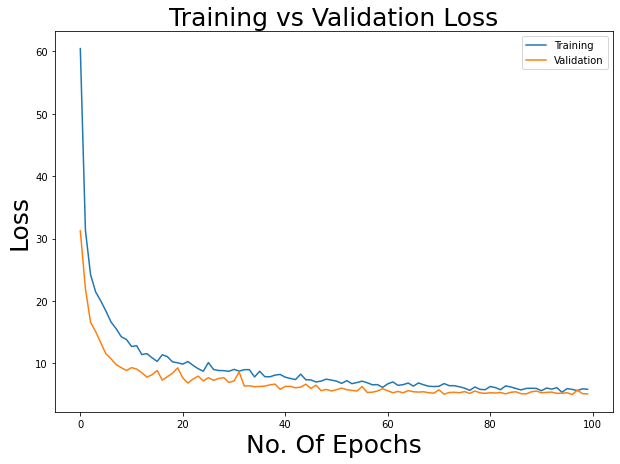


Kappa Score: 0.9652483419513401

------------------- Bi-LSTM Model with FsTxTP Embeddings -------------------


------------------- Cnn-LSTM Model with FsTxTP Embeddings -------------------

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 64)             57664     
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 156,609
Trainable params: 156,609
Non-trainab

Epoch 53/100
284/284 [==============================] - 1s 4ms/step - loss: 7.4277 - mae: 1.5844 - val_loss: 8.0234 - val_mae: 1.5173
Epoch 54/100
284/284 [==============================] - 1s 4ms/step - loss: 7.5640 - mae: 1.5873 - val_loss: 7.9116 - val_mae: 1.5098
Epoch 55/100
284/284 [==============================] - 1s 4ms/step - loss: 7.3632 - mae: 1.5739 - val_loss: 8.1642 - val_mae: 1.5278
Epoch 56/100
284/284 [==============================] - 1s 4ms/step - loss: 7.3464 - mae: 1.5693 - val_loss: 8.2159 - val_mae: 1.5273
Epoch 57/100
284/284 [==============================] - 1s 4ms/step - loss: 7.4409 - mae: 1.5758 - val_loss: 8.0467 - val_mae: 1.5120
Epoch 58/100
284/284 [==============================] - 1s 4ms/step - loss: 7.0523 - mae: 1.5331 - val_loss: 8.0985 - val_mae: 1.5161
Epoch 59/100
284/284 [==============================] - 1s 4ms/step - loss: 7.1347 - mae: 1.5444 - val_loss: 7.7515 - val_mae: 1.4919
Epoch 60/100
284/284 [==============================] - 1s 4ms

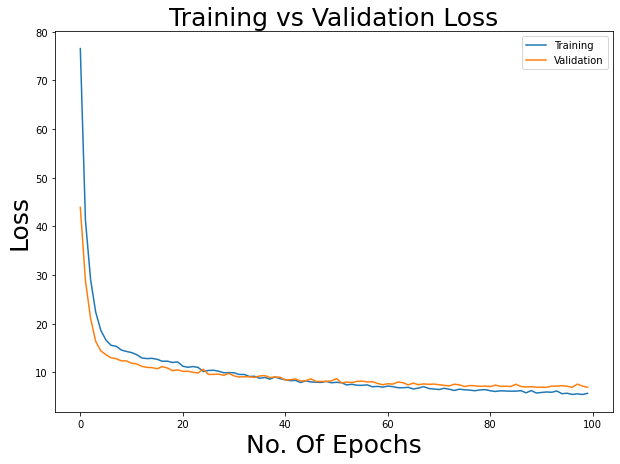


Kappa Score: 0.9539038337309971

------------------- Cnn-LSTM Model with FsTxTP Embeddings -------------------



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
    
X_train,X_test,y_train,y_test = train_test_split(X, Y, train_size=0.70,test_size=0.30, random_state=0)
print('\nShape of X_train and y_train respectively.\n')
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
    
train_essays = X_train['essay']
test_essays = X_test['essay']
   
sentences = []
    
for essay in train_essays:
    # Obtaining all sentences from the training essays.
    sentences += essay_to_sentences(essay, remove_stopwords = True)

models = ['Dual-LSTM','Bi-LSTM','Cnn-LSTM']
embeddings = ['W2V','W2VP','GloVe','FsTxT','FsTxTP']

# dataframe to store our final result
final = {
    embeddings[0]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[1]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[2]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[3]:{models[0]:0,models[1]:0,models[2]:0},
    embeddings[4]:{models[0]:0,models[1]:0,models[2]:0}     
}

for i in range(5): # for every word embedding
    
    if(i==0):
        model = Word2Vec(
            sentences, 
            workers=num_workers, 
            size=num_features, 
            min_count = min_word_count, 
            window = context, 
            sample = downsampling
        )
        model.init_sims(replace=True) # for normalizing
    
    if(i==1):
        model = modelbasic
        modelbasic.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.epochs)
        modelbasic.init_sims(replace=True) # for normalizing
        modelbasic.save("./word2vec/word2vecPre.model") # saving model
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    if(i==2):
        model = modelglove
        modelglove.train(allsentences,total_examples=len(allsentences), epochs=modelbasic.epochs)
        modelglove.init_sims(replace=True) # for normalizing
        modelglove.save("./glove/gloveW2V.model") # saving model
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    if(i==3):
        model = FastText(
            sentences, 
            workers=num_workers, 
            size=num_features, 
            min_count = min_word_count, 
            window = context, 
            sample = downsampling
        )
        model.init_sims(replace=True) # for normalizing
    
    if(i==4):
        model = ftmodelPre
        model.train(sentences,total_examples=len(sentences), epochs=model.epochs)
        model.init_sims(replace=True) # for normalizing
    
    # Generate training and testing data word vectors.
    clean_train_essays = []
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)

    clean_test_essays = []
    for essay_v in test_essays:
        clean_test_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )

    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    
    # Reshaping train and test vectors to 3 dimensions for LSTM (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))

    for j in range(3): # for every model

        print('\n------------------- {} Model with {} Embeddings -------------------\n'.format(models[j],embeddings[i]))

        lstm_model = get_model(j)
        history = lstm_model.fit(
            trainDataVecs, 
            y_train, 
            validation_data=(testDataVecs,y_test), 
            batch_size=32, 
            epochs=100, 
            shuffle = False
        ) 
        # fitting of the model

        # This can be used for prediction
        # lstm_model.load_weights('./final_lstm.h5') To load model weight
        # Predicting from test data
        y_pred = np.around(lstm_model.predict(testDataVecs))
        # lstm_model.save('./final_lstm.h5')
        
        # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
        result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
        final[embeddings[i]][models[j]] = result
        
        print()
        plt.figure(figsize=(10,7))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Training vs Validation Loss', size=25)
        plt.ylabel('Loss', size=25)
        plt.xlabel('No. Of Epochs', size=25)
        plt.legend(['Training','Validation'], loc= 'upper right' )
        plt.show()
        
        print("\nKappa Score: {}".format(result))
        print('\n------------------- {} Model with {} Embeddings -------------------\n'.format(models[j],embeddings[i]))

## Score Comparison
Here we compare our kappa score for different LSTM - Models


Final Scores Matrix: 

                W2V      W2VP     GloVe     FsTxT    FsTxTP
Dual-LSTM  0.966111  0.970293  0.970284  0.966540  0.962526
Bi-LSTM    0.965670  0.972073  0.971534  0.967103  0.965248
Cnn-LSTM   0.955875  0.959390  0.960205  0.957690  0.953904



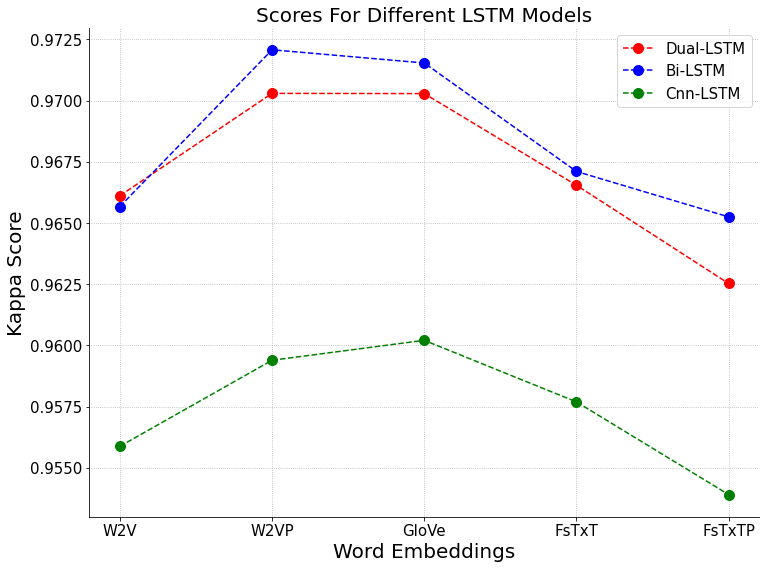

In [15]:
scoreDb = pd.DataFrame(final)

print('\nFinal Scores Matrix: \n')
print(scoreDb)
print()
plt.figure(figsize=(12,9))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Word Embeddings",size=20)
plt.ylabel("Kappa Score",size=20)
plt.title("Scores For Different LSTM Models",size=20)
color = ['red','blue','green']
plt.grid(True, linestyle=':')
plt.tick_params(labelsize=15)
for i in range(3):
    plt.plot(scoreDb.columns.values,scoreDb.iloc[i].values,color=color[i], marker='o', linestyle='--', markersize=10)
plt.legend(scoreDb.index.values, fontsize =15)
plt.show()

## Implementing Multinomial Naive Bayes from Scratch
Implementing multinomial naive bayes on the basic of word frequency count considering only top 3000 frequent words in the whole corpus.


In [16]:
import math as ma
import itertools # this is to slice the dictionary to get only max frequecvy values
from nltk.tokenize import word_tokenize # used to tokenize the sentences
stop_words = set(stopwords.words('english'))

def probability(dictionary,x,score): # it returns the actual probability of input x over class clas

    count = ma.log(dictionary[score]["count"]) - ma.log(dictionary["total"]) # it is probability for a certain score
    features_number = len(dictionary[score].keys()) - 2 # total number of features
    for j in range(features_number): # calculting the probabilty over each feature the later we will take log() sum of all       
        
        if(x[j]==0): # if input x have zero frequency over the feature so its probability will not counted
            continue
        
        count_xj_in_feature_j = dictionary[score][j] + 1 # it is the total frequency of feature j in a score
        # adding one to eliminate any domain specific errors
        count_clas_ele_in_feature = dictionary[score]["Grand_total"] # it is total number of words in a score
        p = ma.log(count_xj_in_feature_j) - ma.log(count_clas_ele_in_feature) 
        # summing all small probabilities of all features
        count = count + p
    return count # returning the probabilty

def singlecol(dictionary,x): # singlecol gives the prediction(output) of single colum at a time
    
    best_prob = -1 # giving any value to initialise best_prob
    best_cls = -1 # giving any value to initialise best_cls
    classes = dictionary.keys() # dictionary .keys have all the classes names
    val = True
    for clas in classes: # checking probabily on one class at a time 
        
        if (clas=="total"): # total is not a class so ignore it
            continue
        
        clas_p = probability(dictionary,x,clas) # clas_p will have probability of input x for class clas
        
        if(val or clas_p>best_prob):
            best_prob = clas_p
            best_cls = clas
        
        val = False
    return best_cls

X_naive = X['essay'].tolist()
Y_naive = X['domain1_score'].tolist()
sets = X['essay_set'].tolist()

# normalizing score
for i in range(len(sets)):
    Y_naive[i] = Y_naive[i] - minimum_scores[sets[i]]
    Y_naive[i] = int(np.around((Y_naive[i] * 5) / (maximum_scores[sets[i]] - minimum_scores[sets[i]])))

# doing hold out spliting for train and test data
xtrain,xtest,ytrain,ytest = train_test_split(X_naive,Y_naive,test_size=0.3,random_state=0)

len_data = len(xtrain)

# in this dictionary we will store frequency of each word from entire dataset by removing stop_words
dictionary = dict()
for j in range(len_data):
    data = xtrain[j]
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
    for word in filtered_sentence:
        if word in dictionary:
            dictionary[word]+=1
        else:
            dictionary[word]=1

new_dict={} # this is the reverse sorted form of dictionary used above
for key,value in sorted(dictionary.items(),key=lambda item: item[1],reverse=True):
    new_dict[key]=value

# slicing over bigger ditionary to get max  frequency 3000 data only
a=dict(itertools.islice(new_dict.items(),3000))
     
features=[] # features is the list of keys of dictionary (a) 
for i in a.keys():
    features.append(i)

# modifing x_train and x_test to 2d Lists having frequency of each word of features 
xx_train=np.zeros((len(xtrain),len(features)))
for i in range(len(xtrain)):
    data=xtrain[i]
    
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for j in filtered_sentence:
        if j in features:
            xx_train[i][features.index(j)]+=1
            
xx_test=np.zeros((len(xtest),len(features)))
for i in range(len(xtest)):
    data2 = xtest[i]
    word_tok = word_tokenize(data2)
    
    fil_sentence = [w for w in word_tok if not w in stop_words]
    
    for j in fil_sentence:
        if j in features:
            xx_test[i][features.index(j)]+=1

# this is to train algorithm over training data
result = {} # we will use dictionary and create nested dictionary where needed
classes = set(ytrain)

for current_class in classes: # accessing all score classes one by one 
    x_train_current = []   
    y_train_current = []
    result[current_class] = {}
    result["total"] = len(xx_train) # it will hold length of entire xx_train set
    for i in range(len(ytrain)):

        if (Y_naive[i]==current_class):
            x_train_current.append(xx_train[i])
            y_train_current = Y_naive[i] # spliting y_train for only current_class
    
    result[current_class]["count"] = len(x_train_current) # it will hold count of current_class
    features_total = xx_train.shape[1] # feature size is nothin but the columns of xx_train
    a = 0
    for j in range(len(features)):
        result[current_class][j]=0
        for k in range(len(x_train_current)):
            result[current_class][j] += x_train_current[k][j] # it will hold frequency of feature j
        a += result[current_class][j]
    result[current_class]["Grand_total"] = a  # it will hold count of entire words in current_class
    
ypred = []
for x in xx_test: # going through test_data row wise
    pred=singlecol(result,x) # as we get a answer by one column we are appending it to list
    ypred.append(pred)    
    
from sklearn import metrics # For AUC score
from sklearn.metrics import classification_report,confusion_matrix
#importing these to check correctness of y_pred(output)

print('\nThis classification is due to our implementation\n')
print(classification_report(ytest,ypred))
fpr, tpr, thresholds = metrics.roc_curve(ytest,ypred, pos_label=2)
auc_score = metrics.auc(fpr, tpr)
print('\nAUC Score: {}'.format(auc_score))

print('\n---------------------COMPARISION---------------------\n')
print('\nThis classification is due to sklearn library\n')

from sklearn.naive_bayes import MultinomialNB # now doing the same fit and predict by MultinomialNB library function
arg1=MultinomialNB()
arg1.fit(xx_train,ytrain)
ypred2=arg1.predict(xx_test)
print(classification_report(ytest,ypred2))
fpr, tpr, thresholds = metrics.roc_curve(ytest,ypred2, pos_label=2)
auc_score = metrics.auc(fpr, tpr)
print('\nAUC Score: {}'.format(auc_score))


This classification is due to our implementation

              precision    recall  f1-score   support

           0       0.00      0.02      0.01       124
           1       0.04      0.13      0.06       235
           2       0.41      0.24      0.30      1188
           3       0.18      0.13      0.15      1138
           4       0.12      0.06      0.08       793
           5       0.07      0.06      0.07       415

    accuracy                           0.14      3893
   macro avg       0.14      0.11      0.11      3893
weighted avg       0.21      0.14      0.16      3893


AUC Score: 0.5765601175028163

---------------------COMPARISION---------------------


This classification is due to sklearn library

              precision    recall  f1-score   support

           0       0.17      0.61      0.27       124
           1       0.35      0.41      0.38       235
           2       0.48      0.19      0.28      1188
           3       0.53      0.42      0.47      1138


## Confusion Matrix for Naive Bayes 
The brighter colors and higher value number around the diagonal shows the accuracy of our model and dispersion shows the low precision.

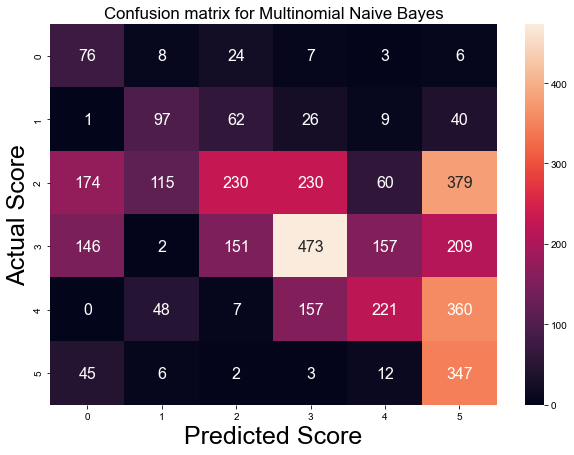

In [17]:
import seaborn as sns # for seaborn 

plt.figure(figsize=(10,7))
array = confusion_matrix(ytest,ypred2)
df_cm = pd.DataFrame(array, range(6), range(6))
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size
sns.set(font_scale=1.4) # for label size
plt.xlabel("Predicted Score", size=25)
plt.ylabel("Actual Score", size=25)
plt.tick_params(labelsize=10)
plt.title("Confusion matrix for Multinomial Naive Bayes")
plt.show(fig)